<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/19August_SEM_Conv2d_V1_M0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia
from kornia import filters
import torch.nn as nn
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 
import matplotlib.image as mpimg
import torchvision
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from PIL import Image

     |████████████████████████████████| 204kB 2.6MB/s 


In [2]:
#from google.colab import drive 
#drive.mount("/content/drive")

In [4]:
!unzip /content/M0_120_class_images.zip -d /content/
!unzip /content/M0_Test_Data.zip -d /content/

Archive:  /content/M0_120_class_images.zip
replace /content/M0_Selected_class_images/Defect_103973_Class_1_Internal.tiff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/M0_Selected_class_images/Defect_103973_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_105326_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_105665_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_107357_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_107695_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_109387_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_111079_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_111418_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_111756_Class_1_Internal.tiff  
  inflating: /content/M0_Selected_class_images/Defect_113786_Class_1_Inte

In [ ]:
#!unzip '/content/drive/My Drive/AutoEncoder_training.zip' -d '/content/drive/My Drive/AutoEncoder_training' 

In [6]:
#Data_path = "/content/Fruits/"
#Data_path = "/content/drive/My Drive/AutoEncoder_training/AutoEncoder_training/"
#Data_path = "/content/drive/My Drive/All_class_images"
Data_path = "/content/M0_Selected_class_images"
Test_Data_path = "/content/M0_Test_Data"

Lets Resize all images to same size

In [5]:
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 226):
    #self.filelist = glob.glob(path+'/*.jfif')
    self.filelist = glob.glob(path+'/*.tiff')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    temp_filepath = self.filelist[idx]
    temp_image = cv2.imread(temp_filepath)
    #print(temp_image)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #dim = (504,504)
    #temp_image = cv2.resize(temp_image, dim, interpolation = cv2.INTER_AREA)
    #print('Resized Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #print(temp_image.shape)
    temp_image = temp_image/255
    #plt.imshow(temp_image,cmap='gray',vmin=0,vmax=1)
    #temp_image = torch.from_numpy(temp_image)
    temp_image = torch.Tensor(temp_image)
    #print(temp_image.shape)
    #print(temp_image)
    temp_image = temp_image.unsqueeze(0)
    #print(temp_image.shape)
    return temp_image

In [7]:
Data = CustomDataset(Data_path)
Test_data = CustomDataset(Test_Data_path)
Data[2].shape

torch.Size([1, 504, 504])

In [13]:
latent_dim = 128

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.enc1 = nn.Conv2d(1,64,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(64,128,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(128,256,kernel_size=2,stride=2)
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        self.FC1 = nn.Linear(12544,2048)
        self.FC2 = nn.Linear(2048,512)
        self.FC3 = nn.Linear(512,latent_dim)

    def forward(self,x):
        conv1 = F.relu(self.enc1(x)) # output will be 168x168x64
        x,indices1 = self.pool(conv1) #output will be 84x84x64
        conv2 = F.relu(self.enc2(x)) #output will be 28x28x128
        x,indices2 = self.pool(conv2)   # output will be 14x14x128
        conv3 = F.relu(self.enc3(x)) #output will be 5x5x256 
        x = conv3.view(-1,12544) # after flattening the size will be 12544
        x = F.relu(self.FC1(x))
        x = F.relu(self.FC2(x))
        x = F.relu(self.FC3(x)) # the latent space representation
        return x,indices1,indices2,conv3,conv2,conv1
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.FC4 = nn.Linear(latent_dim,512)
        self.FC5 = nn.Linear(512,2048)
        self.FC6 = nn.Linear(2048,12544)
        self.dec1 = nn.ConvTranspose2d(256,128, kernel_size=2, stride=2)  
        self.dec2 = nn.ConvTranspose2d(128,64, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(64 ,1, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2,padding=0)
        
        
    def forward(self,x,indices1,indices2,conv3,conv2,conv1):
        x = F.relu(self.FC4(x))
        x = F.relu(self.FC5(x))  #size back to 2048
        x = F.relu(self.FC6(x)) #size back to 12544
        x = torch.reshape(x,(1,256,7,7))
        x = F.relu(self.dec1(x)) # ouput will be 14x14x128
        x = self.unpool(x,indices2) #output will be 28x28x128
        x = F.relu(self.dec2(x)) # output will be 84x84x64
        x = self.unpool(x,indices1) #output will be 168x168x64
        #x = self.dec3(x) # output will be 504x504x1
        x = torch.sigmoid(self.dec3(x)) # output will be 504x504x1
        return x
    
class Conv2d_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv2d_AutoEncoder, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        
        z,indices1,indices2,conv3,conv2,conv1 = self.enc(x)
        
        out = self.dec(z,indices1,indices2,conv3,conv2,conv1)
        
        return out

**Lets write the first Auto encoder **

In [14]:
net = Conv2d_AutoEncoder()
print(net)
if torch.cuda.is_available():
    net.cuda()
#summary(net,input_size=(1,504,504))

Conv2d_AutoEncoder(
  (enc): Encoder(
    (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(3, 3))
    (enc2): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3))
    (enc3): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (FC1): Linear(in_features=12544, out_features=2048, bias=True)
    (FC2): Linear(in_features=2048, out_features=512, bias=True)
    (FC3): Linear(in_features=512, out_features=128, bias=True)
  )
  (dec): Decoder(
    (FC4): Linear(in_features=128, out_features=512, bias=True)
    (FC5): Linear(in_features=512, out_features=2048, bias=True)
    (FC6): Linear(in_features=2048, out_features=12544, bias=True)
    (dec1): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (dec2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(3, 3))
    (dec3): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(3, 3))
    (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2

In [15]:
train_loader = DataLoader(Data,batch_size=1)

In [16]:
loss_func = nn.MSELoss()
#loss_func = nn.L1Loss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 


Training the Auto encoder

In [17]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

n_epochs = 200

if torch.cuda.is_available():
    net.cuda()

total_loss = []
epoch_loss = 0
net.train()
for epoch in tqdm(range(n_epochs)):
    print("current epoch is:",epoch)
    epoch_loss = 0
    for x in train_loader:
        mse_loss = 0
        loss_der = 0
        if torch.cuda.is_available():
          x = x.cuda()
        optimizer.zero_grad()
        prediction = net(x)
        SpatialGradient = filters.SpatialGradient()
        loss_der = loss_func(SpatialGradient(prediction), SpatialGradient(x))
        mse_loss = loss_func(prediction, x) 
        (mse_loss+loss_der).backward()
        optimizer.step()
        epoch_loss = epoch_loss + mse_loss.item() + loss_der.item()

    total_loss.append(epoch_loss)
    print('Loss Per epoch: ',epoch_loss)
    

current epoch is: 0
Loss Per epoch:  7.575594542257022
current epoch is: 1
Loss Per epoch:  6.733351391274482
current epoch is: 2
Loss Per epoch:  6.295103747630492
current epoch is: 3
Loss Per epoch:  6.000824055983685
current epoch is: 4
Loss Per epoch:  5.782433430780657
current epoch is: 5
Loss Per epoch:  5.5895796893164515
current epoch is: 6
Loss Per epoch:  5.422665996127762
current epoch is: 7
Loss Per epoch:  5.2721125250682235
current epoch is: 8
Loss Per epoch:  5.105920874280855
current epoch is: 9
Loss Per epoch:  5.180274935555644
current epoch is: 10
Loss Per epoch:  4.842474844539538
current epoch is: 11
Loss Per epoch:  4.701610696851276
current epoch is: 12
Loss Per epoch:  4.555598781676963
current epoch is: 13
Loss Per epoch:  4.457491984008811
current epoch is: 14
Loss Per epoch:  4.399393331841566
current epoch is: 15
Loss Per epoch:  4.327691864687949
current epoch is: 16
Loss Per epoch:  4.224183680606075
current epoch is: 17
Loss Per epoch:  4.140737221459858


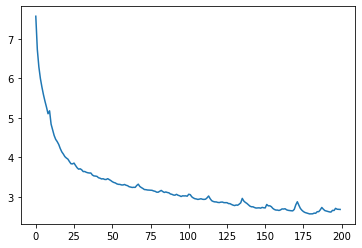

In [18]:
import matplotlib.pyplot as plt
plt.plot(total_loss)

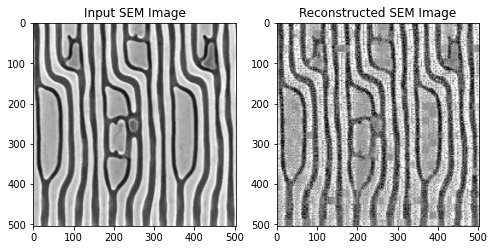

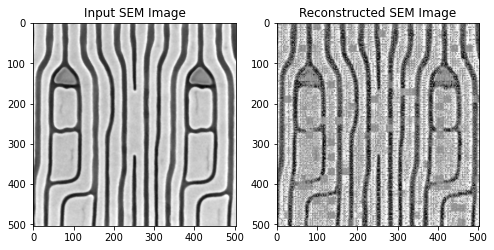

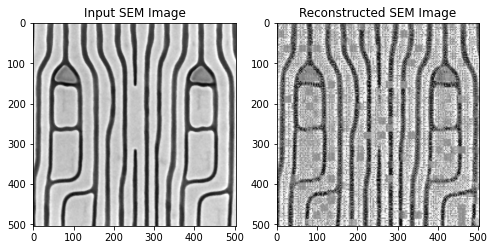

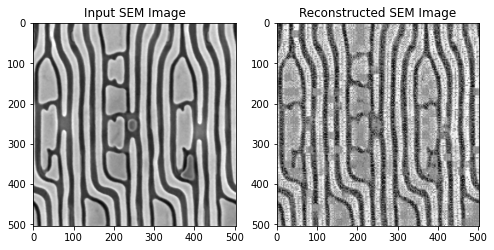

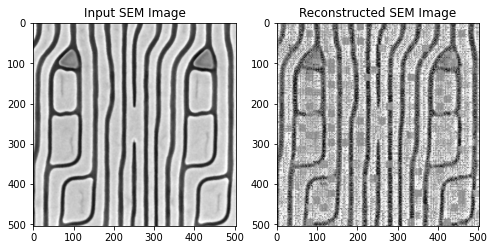

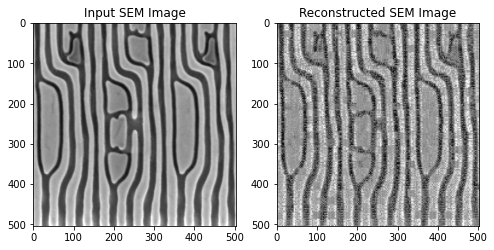

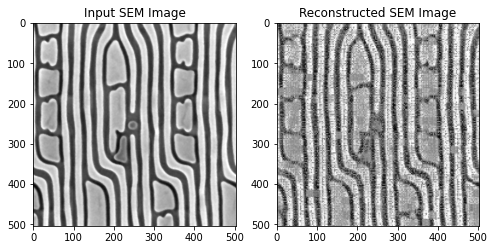

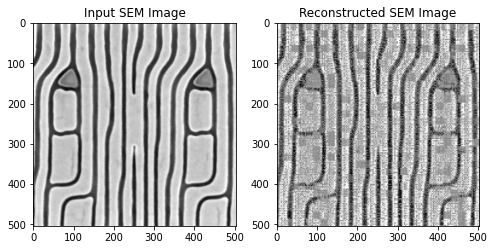

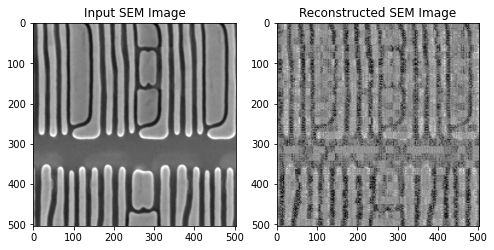

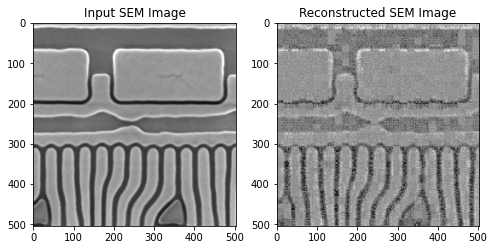

In [19]:
net.cpu()
net.eval()
counter = 0
for i in range(10):
    counter = counter + 1
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    x = Data[i]
    input_img = x[0]
    #print(input_img)
    model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]
    #print(model_pred)
    ax[0].set_title('Input SEM Image',fontsize=12)
    ax[1].set_title('Reconstructed SEM Image',fontsize=12)
    ax[0].imshow(input_img,cmap='gray',vmin=0,vmax=1)
    ax[1].imshow(model_pred,cmap='gray',vmin=0,vmax=1)


Extract Latent representation from Encoder 

Do Clustering and calculate Silhouette Score

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing
Encoder_net = Encoder()
Attributes = np.empty([len(train_loader),latent_dim])

#print(Attributes.shape)
for i,x in enumerate(Data):
  Temp_results = Encoder_net(x.unsqueeze(0))
  #print(Temp_results[0])
  Temp_Attributes = (Temp_results[0]).cpu().data.numpy()
  #print("Temp_Attributes:",Temp_Attributes)
  Attributes[i] = Temp_Attributes
  #print(Attributes[i].shape)
print(Attributes)


[[0.04007962 0.01942839 0.         ... 0.         0.01882323 0.02355525]
 [0.0413432  0.01914414 0.         ... 0.         0.01911091 0.02336249]
 [0.04011294 0.01809738 0.         ... 0.         0.01914246 0.02313668]
 ...
 [0.0394658  0.01734747 0.         ... 0.         0.01899962 0.02205561]
 [0.03792928 0.01625579 0.         ... 0.         0.01825638 0.0217731 ]
 [0.03904856 0.01846835 0.         ... 0.         0.01930493 0.02102544]]


In [21]:


#On test set
Attributes_Test = np.empty([len(Test_data),128])
#print(Attributes.shape)
for i,x in enumerate(Test_data):
  Temp_results1 = Encoder_net(x.unsqueeze(0))
  #print(Temp_results[0])
  Temp_Attributes1 = (Temp_results1[0]).cpu().data.numpy()
  #print("Temp_Attributes:",Temp_Attributes)
  Attributes_Test[i] = Temp_Attributes1
  #print(Attributes[i].shape)
#print(Attributes.shape)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


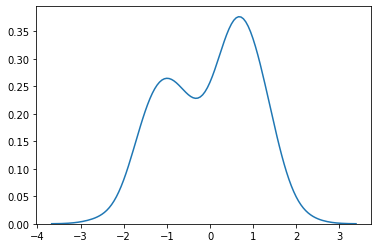

In [22]:
Attributes.shape
Attributes_scaled = preprocessing.scale(Attributes)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
Attributes_scaled2 = selector.fit_transform(Attributes_scaled)

# import pandas as pd
import numpy as np
np.savetxt('ScaledAttr2.txt',Attributes_scaled2)

import seaborn as sns
sns.kdeplot(Attributes_scaled2[:,4])

In [23]:
# Attributes_scaled2.shape
# import seaborn as sns
# for i in range(70):
#   sns.kdeplot(Attributes_scaled2[:,i])
# # Attributes_scaled2[1,:]

In [24]:
from sklearn.feature_selection import VarianceThreshold
k=10
Attributes_scaled = preprocessing.scale(Attributes)
print(Attributes_scaled.shape)
#print(Attributes_scaled.mean(axis=0))
print(Attributes_scaled.std(axis=0))
selector = VarianceThreshold()
Attributes_scaled = selector.fit_transform(Attributes_scaled)
print(Attributes_scaled.shape)
#print(Attributes_scaled.mean(axis=0))
print(Attributes_scaled.std(axis=0))
kmeans = KMeans(n_clusters=k,random_state=0).fit(Attributes_scaled)
Clustering_labels = kmeans.labels_
print(Clustering_labels)
Score = silhouette_score(Attributes_scaled,Clustering_labels,metric='euclidean')
print(Score)
sample_score = silhouette_samples(Attributes_scaled,Clustering_labels,metric='euclidean')
#print(sample_score)

(120, 128)
[1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1.]
(120, 82)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[9 8 8 7 2 6 9 2 6 0 5 9 7 0 9 1 6 0 4 8 9 6 5 2 9 4 4 2 0 9 6 6 6 4 6 6 7
 5 6 0 5 5 4 1 5 2 6 0 6 8 5 8 9 5 6 4 6 3 5 0 8 6 8 6 4 4 6 5 9 8 8 5 3 3
 5 3 9 4 5 3 5 1 9 4 6 6 3 8 3 6 4 2 8 9 6 5 3 2 4 8 0 4 6 5 6 5 6 2 4 3 6
 6 3 8 6 4 3 4 6 4]
0.12815277025208427


In [25]:
print(Score)

0.12815277025208427


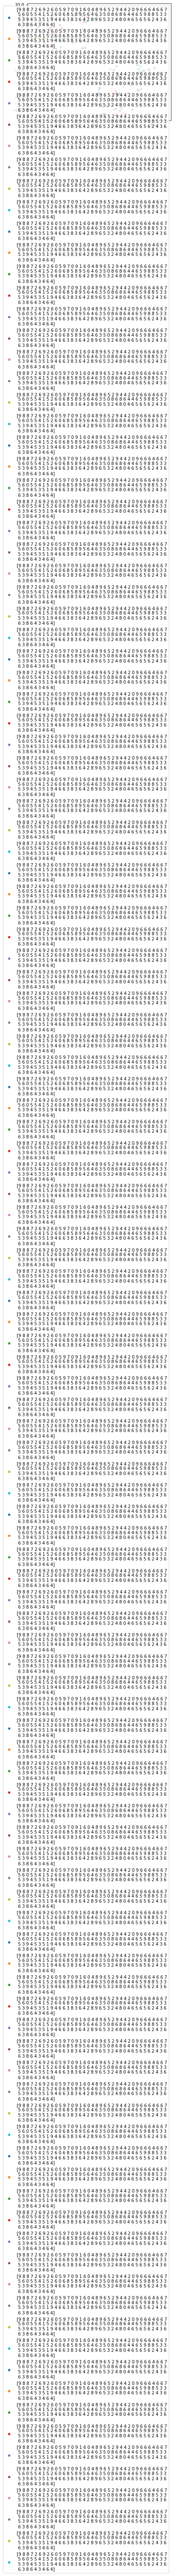

[9 8 8 7 2 6 9 2 6 0 5 9 7 0 9 1 6 0 4 8 9 6 5 2 9 4 4 2 0 9 6 6 6 4 6 6 7
 5 6 0 5 5 4 1 5 2 6 0 6 8 5 8 9 5 6 4 6 3 5 0 8 6 8 6 4 4 6 5 9 8 8 5 3 3
 5 3 9 4 5 3 5 1 9 4 6 6 3 8 3 6 4 2 8 9 6 5 3 2 4 8 0 4 6 5 6 5 6 2 4 3 6
 6 3 8 6 4 3 4 6 4]


In [26]:
#Plot TSNE 
#print(X_embedded)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(Attributes_scaled)
#print(X_embedded.shape)
plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k'
# for i, c, label in zip(range(len(Data)), colors, Clustering_labels):
#     plt.scatter(X_embedded[i, 0], X_embedded[i, 1], c=c, label=label)
for i in range(120):
  plt.scatter(X_embedded[i, 0], X_embedded[i, 1], 20, label = Clustering_labels, cmap='viridis')
plt.legend()
plt.show()
print(Clustering_labels)



In [27]:
type(X_embedded)
type(Clustering_labels)
df111 = pd.DataFrame(X_embedded, columns = ['X1','X2'])
# df111[['X1','X2']] = X_embedded
df111['L'] = Clustering_labels

# import seaborn as sns
# sns.color_palette("bright", 10)
# sns.scatterplot(x='X1',y='X2',hue='L',data=df111,legend='full')

palette = sns.color_palette("bright", 10)  #Choosing color
g = sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1], palette=palette, hue=Clustering_labels, legend='full')
g.legend(loc='right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

NameError: ignored

In [28]:
#On Test Data
k = 10
Attributes_Test_scaled = preprocessing.scale(Attributes_Test)
kmeans_Test = KMeans(n_clusters=k).fit(Attributes_Test_scaled)
Clustering_labels_Test = kmeans_Test.labels_
print(Clustering_labels_Test)
Score_Test = silhouette_score(Attributes_Test_scaled,Clustering_labels_Test,metric='euclidean')
print(Score_Test)
sample_score_Test = silhouette_samples(Attributes_Test_scaled,Clustering_labels_Test,metric='euclidean')

[7 8 5 3 2 3 8 6 4 7 4 3 1 1 0 2 2 3 3 5 8 7 5 2 9 3 6 1 0 6 9 7 7 1 1 7 1
 4 5 5 2 7 8 7 1 5 5 3 8 9]
0.11228576081460453


In [29]:
max(sample_score)

0.49523891502593986

Find Optimal K using Silhouette score

In [30]:
import pandas as pd 
column_names = ["Image","Label","Score"]
df = pd.DataFrame(columns = column_names,index=np.arange(len(Data)))
df['Image'][88]



# for i,x in enumerate(Data):
#   df['Image'][i] = (x[0]).data.numpy()
#   df['Label'][i] = Clustering_labels[i]
#   df['Score'][i] = sample_score[i]
#   #print(input_img)
#   df

#   df.to_csv('Scores.csv')

nan

In [31]:
df_Test = pd.DataFrame(columns = column_names,index=np.arange(len(Test_data)))
df_Test['Image'][48]
for i,x in enumerate(Test_data):
  df_Test['Image'][i] = (x[0]).data.numpy()
  df_Test['Label'][i] = Clustering_labels_Test[i]
  df_Test['Score'][i] = sample_score_Test[i]
  #print(input_img)
df_Test

,Image,Label,Score
0,"[[0.09411765, 0.09803922, 0.11764706, 0.164705...",7,0.121664
1,"[[0.40784314, 0.40784314, 0.40392157, 0.396078...",8,0.153063
2,"[[0.6627451, 0.6627451, 0.6627451, 0.6627451, ...",5,0.0940949
3,"[[0.67058825, 0.5803922, 0.41568628, 0.3294117...",3,0.221866
4,"[[0.9882353, 0.972549, 0.9411765, 0.90588236, ...",2,0.132078
5,"[[0.654902, 0.6392157, 0.6117647, 0.5686275, 0...",3,0.267223
6,"[[0.6901961, 0.6666667, 0.63529414, 0.60784316...",8,-0.0877449
7,"[[0.85882354, 0.85882354, 0.8666667, 0.8862745...",6,0.172715
8,"[[0.6784314, 0.5372549, 0.39607844, 0.33333334...",4,0.0716928
9,"[[0.15294118, 0.15294118, 0.15686275, 0.180392...",7,0.130646


In [32]:
# df= df.sort_values('Label',ignore_index=True)
df = df.sort_values(["Label", "Score"], ascending = (True, False),ignore_index=True)
print(df)
df['Image'][110]

    Image Label Score
0     NaN   NaN   NaN
1     NaN   NaN   NaN
2     NaN   NaN   NaN
3     NaN   NaN   NaN
4     NaN   NaN   NaN
..    ...   ...   ...
115   NaN   NaN   NaN
116   NaN   NaN   NaN
117   NaN   NaN   NaN
118   NaN   NaN   NaN
119   NaN   NaN   NaN

[120 rows x 3 columns]


nan

In [33]:
df_Test= df_Test.sort_values('Label',ignore_index=True)
print(df_Test)
df_Test['Image'][40]

                                                Image Label       Score
0   [[0.74509805, 0.7529412, 0.7647059, 0.78039217...     0    0.141317
1   [[0.1882353, 0.1882353, 0.19607843, 0.21568628...     0    0.281051
2   [[0.654902, 0.65882355, 0.65882355, 0.654902, ...     1    0.107151
3   [[0.6431373, 0.6509804, 0.654902, 0.6509804, 0...     1   0.0105173
4   [[0.6901961, 0.6862745, 0.68235296, 0.6745098,...     1    0.099889
5   [[0.69411767, 0.6862745, 0.68235296, 0.6745098...     1    0.119261
6   [[0.63529414, 0.6313726, 0.627451, 0.627451, 0...     1    0.132895
7   [[0.6666667, 0.65882355, 0.64705884, 0.6196078...     1 -0.00051687
8   [[0.65882355, 0.65882355, 0.6627451, 0.6745098...     1   0.0466455
9   [[1.0, 1.0, 0.9607843, 0.9019608, 0.8784314, 0...     2    0.213102
10  [[0.9607843, 0.94509804, 0.9254902, 0.90588236...     2     0.23698
11  [[0.96862745, 0.9607843, 0.9490196, 0.9372549,...     2    0.228788
12  [[0.9882353, 0.972549, 0.9411765, 0.90588236, ...     2    0

array([[0.827451  , 0.8352941 , 0.8509804 , ..., 0.92156863, 0.9411765 ,
        0.9490196 ],
       [0.8352941 , 0.84313726, 0.8627451 , ..., 0.9137255 , 0.92941177,
        0.9411765 ],
       [0.84313726, 0.85490197, 0.8745098 , ..., 0.9019608 , 0.91764706,
        0.9254902 ],
       ...,
       [0.6509804 , 0.64705884, 0.64705884, ..., 0.2509804 , 0.3372549 ,
        0.42352942],
       [0.654902  , 0.6509804 , 0.6431373 , ..., 0.2901961 , 0.39215687,
        0.50980395],
       [0.654902  , 0.6509804 , 0.64705884, ..., 0.34117648, 0.4862745 ,
        0.5686275 ]], dtype=float32)

120


TypeError: ignored

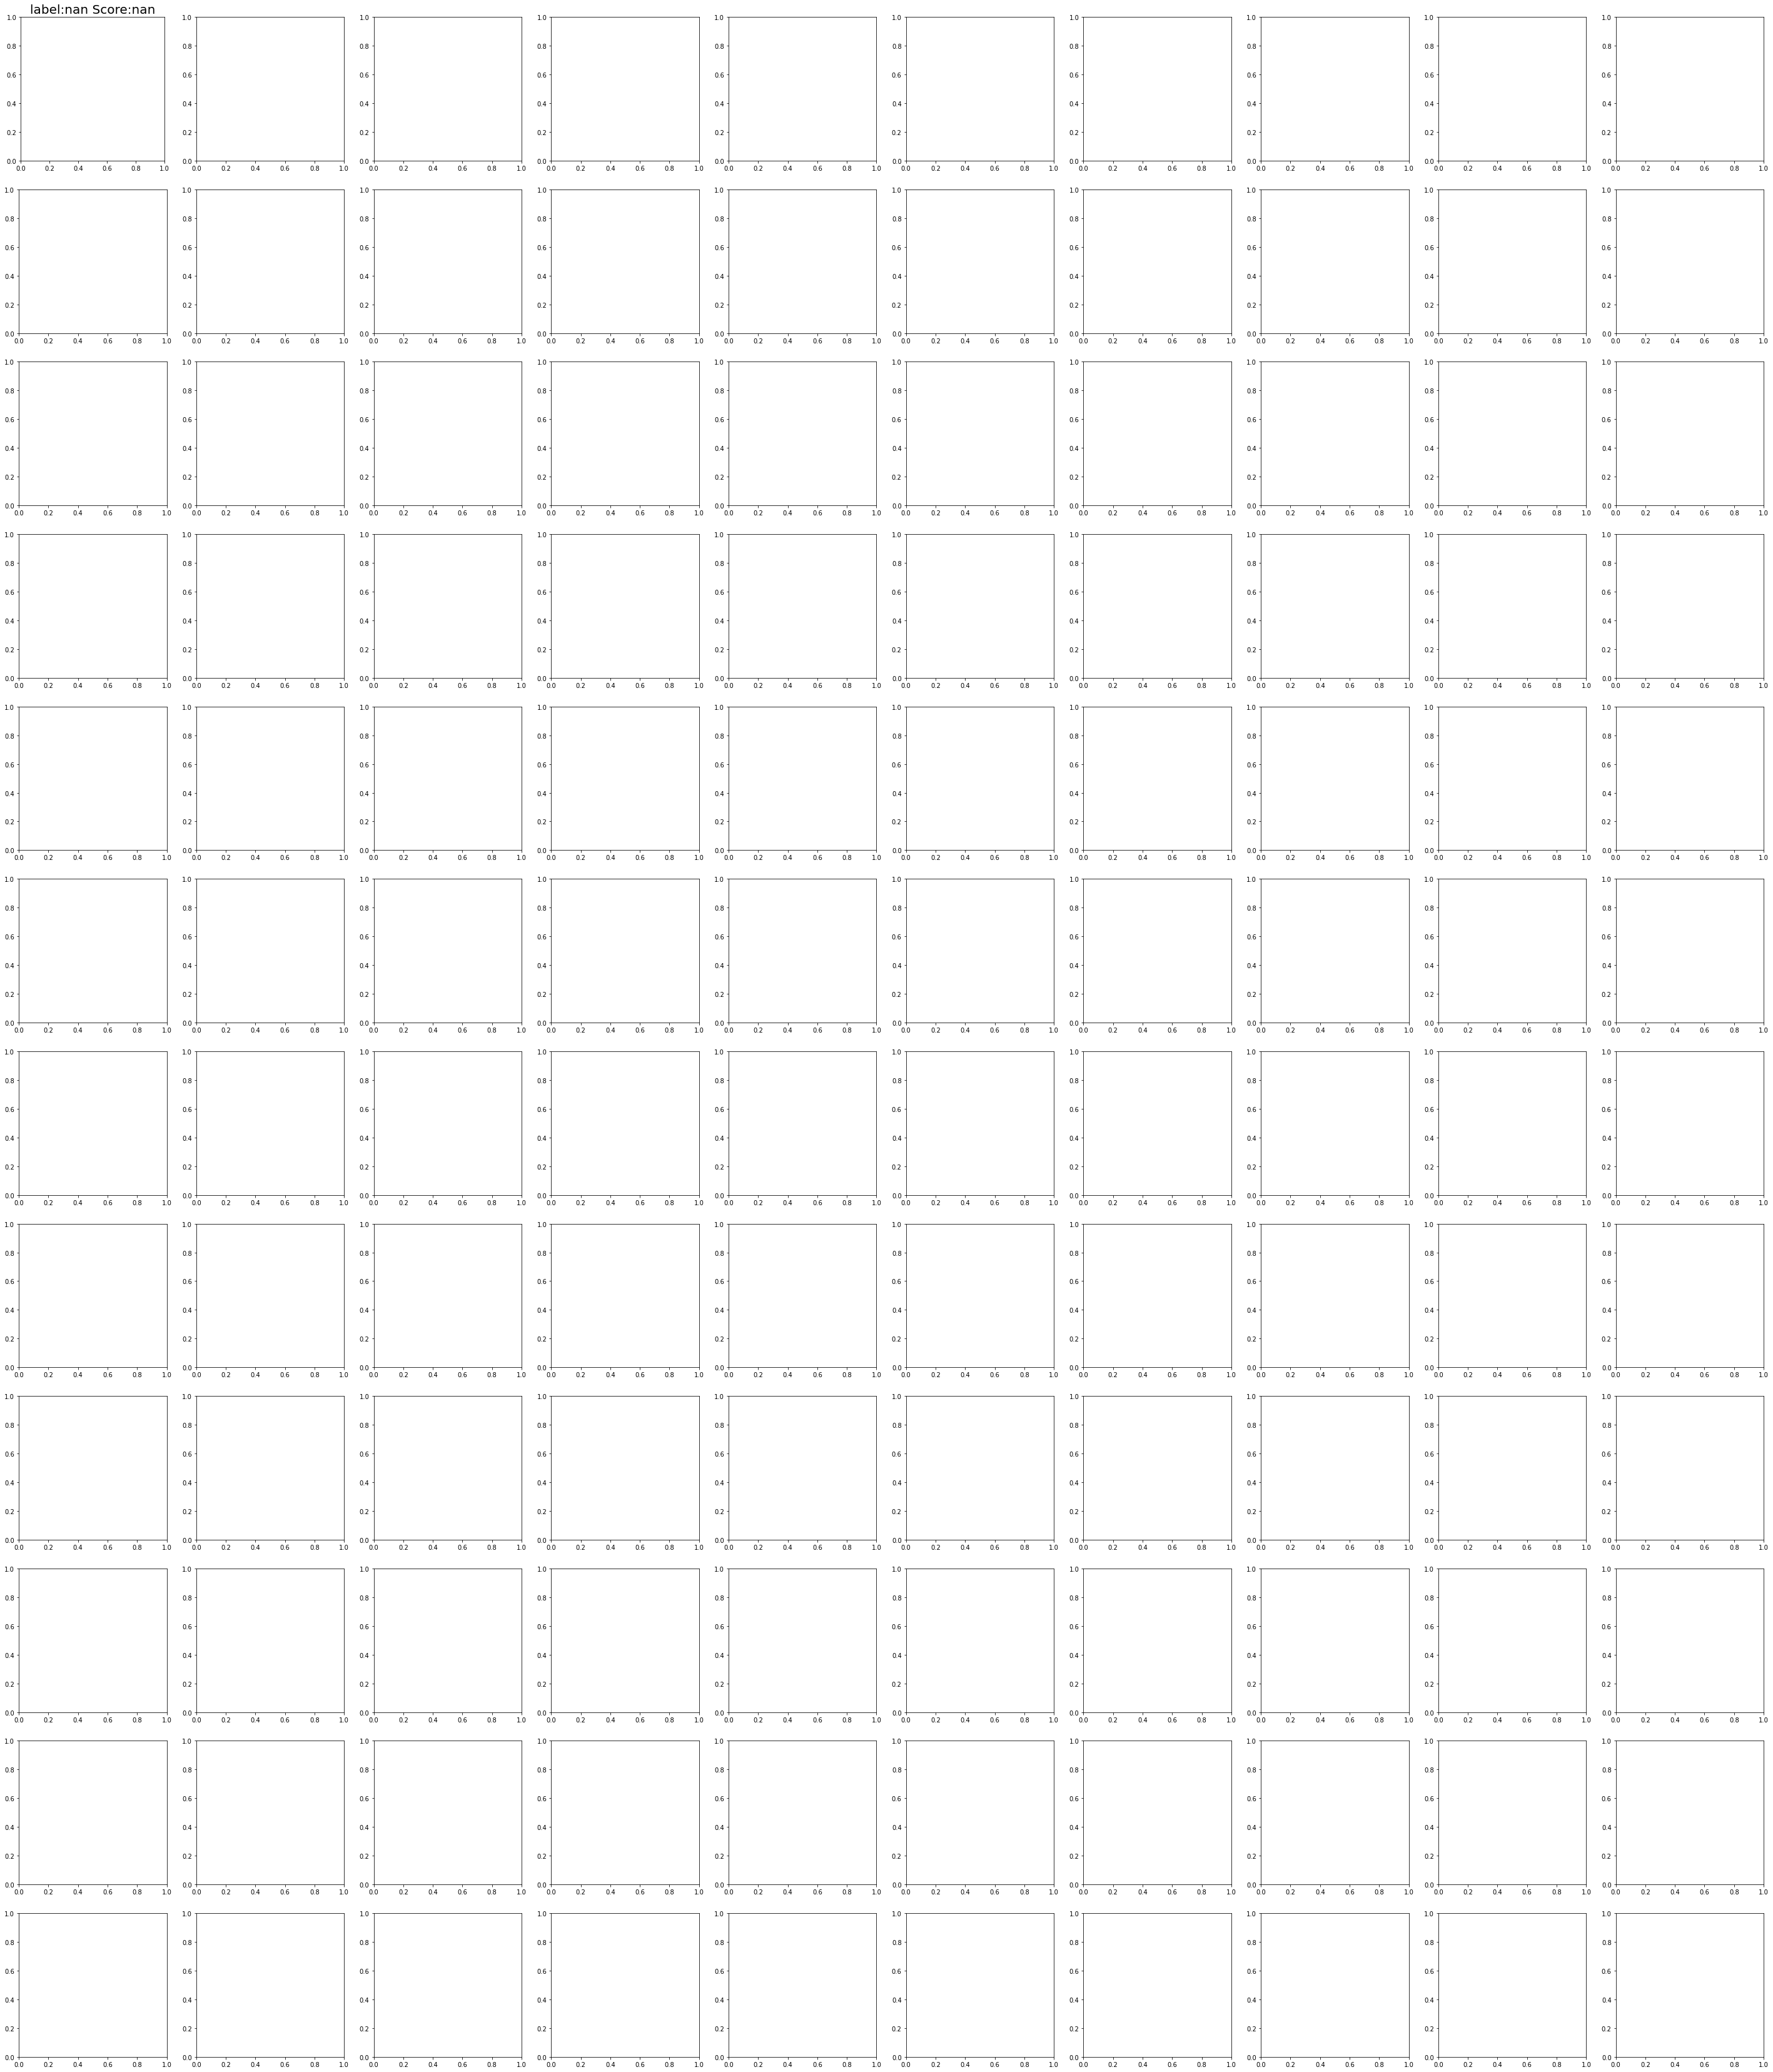

In [34]:
ncols = 10
print(len(Data))
nrows = int(len(Data)/ncols)
figsize = [50, 60]  
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axi = ax.flat
#print(len(axi))
for i,x in enumerate(Data):
  input_img = df['Image'][i]
  axi[i].set_title("label:"+str(df['Label'][i])+" "+"Score:"+str(round(df['Score'][i],2)),fontsize =20)
  axi[i].imshow(input_img,cmap='gray',vmin=0,vmax=1)
fig.tight_layout(pad=0.3)
plt.show

In [ ]:
#Plot test Data
ncols = 5
print(len(Data))
nrows = int(len(Test_data)/ncols)
figsize = [20, 40]  
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axi = ax.flat
#print(len(axi))
for i,x in enumerate(Test_data):
  input_img1 = df_Test['Image'][i]
  axi[i].set_title("label:"+str(df_Test['Label'][i])+" "+"Score:"+str(round(df_Test['Score'][i],2)),fontsize =20)
  axi[i].imshow(input_img1,cmap='gray',vmin=0,vmax=1)
fig.tight_layout(pad=0.3)
plt.show

In [ ]:
k_range = range(4,14)
Distortions = []
Silhouette_Scores = []
for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=0).fit(Attributes_scaled)
  Clustering_labels_k = kmeans.labels_
  Distortions.append(kmeans.inertia_)
  Score = silhouette_score(Attributes_scaled,Clustering_labels_k,metric='euclidean')
  Silhouette_Scores.append(Score)

In [ ]:
#Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(k_range, Distortions, 'bx-')
plt.xlabel('k')
plt.xticks(range(2,31))
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
#Plotting the Silhouette score of K-Means
plt.figure(figsize=(16,8))
plt.plot(k_range, Silhouette_Scores, 'bx-')
plt.xlabel('k')
plt.xticks(range(4,14))
plt.ylabel('Silhouette score')
plt.title('The Silhouette score showing optimal k')